In [4]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import open3d as o3d
import os
import math
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset, random_split, Subset, SubsetRandomSampler

# The Model

In [2]:
class PointCloudAutoEncoder(nn.Module):
    def __init__(self, input_dim=32):
        super(PointCloudAutoEncoder, self).__init__()

        # Encoder: Maps input point cloud to a latent representation
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, stride=2, padding=1),  # Output: (32, input_dim/2, input_dim/2, input_dim/2)
            nn.ReLU(inplace=True),
            nn.Conv3d(16, 32, kernel_size=3, stride=2, padding=1),  # Output: (64, input_dim/4, input_dim/4, input_dim/4)
            nn.ReLU(inplace=True),
            nn.Conv3d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
        )

        # Fully connected layers to create a bottleneck
        grid_count = (input_dim // 4) ** 3
        self.flatBottleneck = nn.Sequential(
            nn.Flatten(),  # Flatten to (N, 64 * grid_count)
            nn.Linear(32 * grid_count, 32 * grid_count),
            nn.ReLU(inplace=True),
            nn.Linear(32 * grid_count, 32 * grid_count),
            nn.ReLU(inplace=True),
            nn.Unflatten(dim=1, unflattened_size=(32, input_dim // 4, input_dim // 4, input_dim // 4))  # Reshape back
        )
        
        #self.flatten = nn.Flatten()  # Flatten spatial dimensions
        # self.fc1 = nn.Linear(128 * (input_dim // 8) ** 3, 128 * (input_dim // 8) ** 3)
        #self.fc2 = nn.Linear(128, 128 * (input_dim // 8) ** 3)
        #self.fc3 = nn.Linear( 128 * (input_dim // 8) ** 3, 128 * (input_dim // 8) ** 3)
        #self.fc4 = nn.Linear( 128 * (input_dim // 8) ** 3, 128 * (input_dim // 8) ** 3)
        #self.unflatten = nn.Unflatten(128 * (input_dim // 8) ** 3, (128, input_dim // 8, input_dim // 8, input_dim // 8))
        
        # Decoder: Maps latent representation back to point cloud
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose3d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose3d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),  # Output values in [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)  # Encode spatial features
        x = self.flatBottleneck(x)
        x = self.decoder(x)  # Decode back to voxel grid
        return x

In [3]:
#
# LOSS METHODS
#

from torch.nn import MSELoss
from torch.nn import BCELoss

"""
COMBINED LOSS
"""
def combined_loss(pred, target):
    loss_fn = BCELoss()
    return loss_fn(pred, target)
    

# Dataset

In [54]:
class VoxelGridDataset(Dataset):
    def __init__(self, root_dir, split="train",transform=None):
        """
        Args:
            root_dir (str): Root directory containing subfolders with .ply files.
            split (str): 'train' or 'val'. Determines the file names.
            target_points (int): Number of points to standardize the point clouds to.
            transform (callable, optional): Optional transform to apply to the point clouds.
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.samples = []
        
        self.voxel_size = None
        self.grid_min_bound = None
        self.grid_min_bound = None

        # Gather all subfolder paths and corresponding files
        """
        for subfolder in os.listdir(root_dir):
            subfolder_path = os.path.join(root_dir, subfolder)
            if os.path.isdir(subfolder_path):
                incomplete_path = os.path.join(subfolder_path, f"{subfolder}h.ply")
                ground_truth_path = os.path.join(subfolder_path, f"{subfolder}.ply")
                if os.path.exists(incomplete_path) and os.path.exists(ground_truth_path):
                    self.samples.append((incomplete_path, ground_truth_path))
        """
        
        lst = os.listdir(root_dir) # your directory path
        number_files = len(lst)

        for i in range(math.floor(number_files / 2)):
            cut_file_path = os.path.join(root_dir, f"{i}_cut.ply")
            full_file_path = os.path.join(root_dir, f"{i}_full.ply")
            if os.path.exists(cut_file_path) and os.path.exists(full_file_path):
                self.samples.append((cut_file_path, full_file_path))
                    
        print(f"Created dataset with {len(self.samples)} entries")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Load the incomplete and ground truth point clouds
        incomplete_path, ground_truth_path = self.samples[idx]

        incomplete_pcd = o3d.io.read_point_cloud(incomplete_path)
        ground_truth_pcd = o3d.io.read_point_cloud(ground_truth_path)

        incomplete_points = self.get_3d_tensor_from_pcd(incomplete_pcd)
        ground_truth_points = self.get_3d_tensor_from_pcd(ground_truth_pcd)
        
        # add one color channel for tensor format
        incomplete_points = incomplete_points.unsqueeze(0)
        ground_truth_points = ground_truth_points.unsqueeze(0) 
        
        # apply gaussian filter as a alternative to signed distance fields
        sigma = 1
        incomplete_points_sdf = VoxelGridDataset.apply_gaussian_filter_with_preservation(incomplete_points, sigma=sigma)
        ground_truth_points_sdf = VoxelGridDataset.apply_gaussian_filter_with_preservation(ground_truth_points, sigma=sigma)

        return incomplete_points_sdf, ground_truth_points_sdf
    
    
    def apply_gaussian_filter_with_preservation(voxel_grid, sigma):
        """
        Applies a Gaussian filter to a 3D voxel grid while preserving original values of 1.
        Args:
            voxel_grid (torch.Tensor): Input tensor of shape (batch, channels, D, H, W).
            sigma (float): Standard deviation of the Gaussian kernel.
        Returns:
            torch.Tensor: Smoothed tensor with original values preserved.
        """
        # Create the 1D Gaussian kernel
        size = int(2 * (3 * sigma) + 1)  # Kernel size (3 sigma rule)
        x = torch.linspace(-size // 2, size // 2, steps=size)
        kernel_1d = torch.exp(-0.5 * (x / sigma)**2)
        kernel_1d = kernel_1d / kernel_1d.sum()  # Normalize to ensure sum of 1
    
        # Create the 3D Gaussian kernel
        kernel_3d = torch.einsum('i,j,k->ijk', kernel_1d, kernel_1d, kernel_1d)
        kernel_3d = kernel_3d / kernel_3d.sum()  # Normalize again for safety
        kernel_3d = kernel_3d.unsqueeze(0).unsqueeze(0)  # Add batch and channel dims
    
        # Apply Gaussian filter using conv3d
        padding = size // 2  # To retain the input size
        blurred = F.conv3d(voxel_grid, kernel_3d, padding=padding)
        mask = (voxel_grid == 1).float()  # Binary mask where the original values are 1
    
        # Combine the smoothed field with the original values
        result = mask * voxel_grid + (1 - mask) * blurred
        
        # remove to small values (bad for training)
        result[result < 0.1] = 0
        
        return result
    
    
    def get_3d_tensor_from_pcd(self, pcd):
        # Extract the points
        points = np.asarray(pcd.points)
        # Get the bounding box of the point cloud to determine the extent of the grid
        min_bound = np.min(points, axis=0)
        max_bound = np.max(points, axis=0)
        # Define the resolution of the 3D grid (e.g., 50x50x50 grid)
        grid_size = 32 # TODO IN PARAMS
        voxel_size = (max_bound - min_bound) / grid_size
        
        self.voxel_size = voxel_size
        self.grid_min_bound = min_bound
        self.grid_min_bound = max_bound
        
        # Normalize the points to the grid space
        normalized_points = (points - min_bound) / voxel_size
        # Round the points to the nearest grid cell
        grid_points = np.floor(normalized_points).astype(int)
        # Clamp the values to ensure they stay within grid bounds
        grid_points = np.clip(grid_points, 0, grid_size - 1)
        # Create the 3D tensor (grid), initially filled with zeros
        grid_tensor = torch.zeros((grid_size, grid_size, grid_size), dtype=torch.int32)
        # Mark the grid cells corresponding to the points as occupied (1)
        for point in grid_points:
            grid_tensor[tuple(point)] = 1
        return grid_tensor.float()
    
def visualize_3d_torch(tensor_3d, min_bound=None, voxel_size=1, threshold=0.5, window_name="Open3D Vis"):
     # Assume a default min_bound if it's not provided
    if min_bound is None:
        min_bound = np.array([1, 1, 1])  # Default assumption

    # Find indices of non-zero elements in the tensor
    occupied_indices = np.argwhere(tensor_3d.numpy() > 0.5)
    # Convert grid indices back to world coordinates
    points = occupied_indices * voxel_size + min_bound
    # Create a point cloud using Open3D
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    o3d.visualization.draw_geometries([pcd], window_name=window_name)

# Training

In [55]:
def validate_autoencoder(model, dataloader, device='cuda'):
    model.eval()
    total_loss = 0.0
    
    with torch.no_grad():
        for incomplete_pc, ground_truth_pc in dataloader:
            incomplete_pc = incomplete_pc.to(device)
            ground_truth_pc = ground_truth_pc.to(device)

            # Get the reconstructed point cloud
            reconstructed_pc = model(incomplete_pc)

            # Calculate the loss against the ground truth
            loss = combined_loss(reconstructed_pc, ground_truth_pc)
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

def train_with_ground_truth(model, optimizer, train_loader, val_loader, epochs=50, device='cuda'):
    model.to(device)
    
    best_loss = float('inf')
    patience = 7
    
    train_losses = []
    val_losses = []
    
    print("starting epochs")
    
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0

        batch_index = 0
        total_length = len(train_loader)
        
        for incomplete_pc, ground_truth_pc in train_loader:

            # process loging
            if batch_index % 50 == 0:
                print(f"epoch progress {batch_index}/{total_length}")
            batch_index += 1
            
            incomplete_pc = incomplete_pc.to(device)
            ground_truth_pc = ground_truth_pc.to(device)
                            
            # Reconstruct point cloud
            reconstructed_pc = model(incomplete_pc)

            # Compute loss against ground truth
            loss = combined_loss(reconstructed_pc, ground_truth_pc)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = validate_autoencoder(model, val_loader, device)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        # Early stopping
        if avg_train_loss < best_loss:
            best_loss = avg_train_loss
            patience = 7  # Reset patience counter
        else:
            patience -= 1
            if patience == 0:
                print("EARLY STOPPING DUE TO MISSING PROGRESS")
                break
        
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

Created dataset with 6 entries
train size: 4, val size: 2
(2, 1, 32, 32, 32)


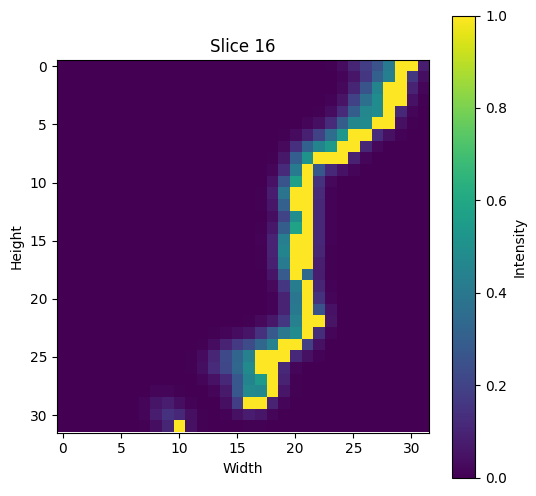

In [56]:
 # Dataset root directory
root_dir = "../assets/voxel10000"

# Create dataset and dataloaders
full_dataset = VoxelGridDataset(root_dir=root_dir, split="train")

#limit to 10k
#indices = np.random.choice(len(full_dataset), size=8000, replace=False)
#subset_d = Subset(full_dataset, indices)

# Define the split ratio (e.g., 80% train, 20% validation)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
print(f"train size: {train_size}, val size: {val_size}")
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

demo_entry = val_dataset[1]
print(np.shape(demo_entry))

# test signed heat map stuff


#visualize_3d_torch(demo_entry[0][0])
#visualize_3d_torch(demo_entry[0][0])

smoothed_field_np = demo_entry[0][0].squeeze().cpu().numpy()  # Convert to NumPy array if it's a PyTorch tensor
slice_index = 16
slice_data = smoothed_field_np[slice_index, :, :]  # Extract the slice (H, W)

# Plot the slice
plt.figure(figsize=(6, 6))
plt.imshow(slice_data, cmap='viridis')  # Use a colormap like 'viridis', 'gray', etc.
plt.colorbar(label='Intensity')
plt.title(f'Slice {slice_index}')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

#full_dataset.visualize_3d_torch(demo_entry[0])
#print(demo_entry)
#visualize_point_cloud(demo_entry)

In [9]:
# Initialize model, optimizer
epochs = 20
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = PointCloudAutoEncoder()
model.to(device)

cuda


PointCloudAutoEncoder(
  (encoder): Sequential(
    (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (3): ReLU(inplace=True)
    (4): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (5): ReLU(inplace=True)
  )
  (flatBottleneck): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=16384, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=16384, out_features=16384, bias=True)
    (4): ReLU(inplace=True)
    (5): Unflatten(dim=1, unflattened_size=(32, 8, 8, 8))
  )
  (decoder): Sequential(
    (0): ConvTranspose3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose3d(32, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), output_padding=(1, 1, 1))
    (3): ReLU(inplace=Tr

In [ ]:
# Train with grund truth
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_with_ground_truth(model, optimizer, train_loader, val_loader, epochs=epochs, device=device)

starting epochs
epoch progress 0/1467


# Evaluation / Test

In [ ]:
# Get a single example
pd_input, pd_truth = train_dataset[3]  # First sample from the dataset
pd_input = pd_input.unsqueeze(0)  # Add batch dimension (1, num_points, 3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pd_input = pd_input.to(device)

#state_dict = torch.load("../assets/model_exports/model_v1.pt")
#model.load_state_dict(state_dict)
#model.eval()

# Run through the model
with torch.no_grad():
    reconstructed_pc = model(pd_input)
    
# Remove batch dimension
pd_input = pd_input.squeeze(0).cpu()
reconstructed_pc = reconstructed_pc.squeeze(0).cpu()
pd_truth = pd_truth.cpu()
#plot_point_cloud(pd_truth)

#print(torch.max(reconstructed_pc))
reconstructed_pc = torch.where(reconstructed_pc > 0.5, 1, 0)
print("reconstructed")
print(f"shape: {np.shape(reconstructed_pc)}")
print(f"max: {torch.max(reconstructed_pc)}")
print(f"sum == 1: {torch.sum(reconstructed_pc == 1)}")
print(f"sum == 0: {torch.sum(reconstructed_pc == 0)}")
print(f"shape: {torch.max(pd_input)}")
print(f"max: {np.shape(pd_input)}")
print(f"sum == 1: {torch.sum(pd_input == 1)}")
print(f"sum == 0: {torch.sum(pd_input == 0)}")

voxel_size = 0.01  # Assuming the original grid covered a 10x10x10 space
min_bound = np.array([3, 1, 2])  # Assume min_bound was at origin
    
visualize_3d_torch(pd_input[0], voxel_size, min_bound, window_name="Input")
visualize_3d_torch(pd_truth[0], voxel_size, min_bound, window_name="Ground Truth")
visualize_3d_torch(reconstructed_pc[0], voxel_size, min_bound, window_name="Predicted")

In [50]:
#torch.save(model, '../assets/model_exports/model_v3.pt')